# Advanced Lane Finding

In [1]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
def get_obj_img_points(nx=9, ny=6):
    # prepare object points, like (0,0,0),
    # (1,0,0),..,(8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points
    # from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search
    # for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,
                                                 (nx, ny),
                                                 None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

# obtain camera calibration parameters

def cal_camera(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                                    objpoints,
                                    imgpoints,
                                    gray.shape[::-1],
                                    None,
                                    None)
    return mtx, dist

# undistort the image

def cal_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

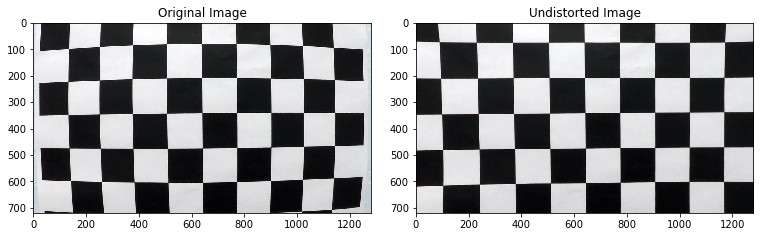

In [3]:
# test calibration parameters by undistoring a sample image

image = cv2.imread('camera_cal/calibration{}.jpg'.format(1))

objpoints, imgpoints = get_obj_img_points()
mtx, dist = cal_camera(image, objpoints, imgpoints)
undistorted = cal_undistort(image, mtx, dist)


%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/camera_calibration.png")

## Apply a distortion correction to raw images.

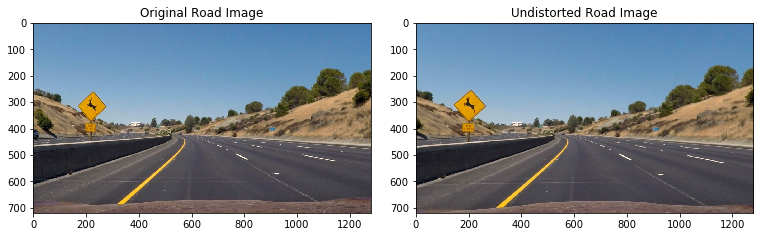

In [4]:
# undistort a raw road image

image = cv2.imread('test_images/test{}.jpg'.format(2))
undistorted = cal_undistort(image, mtx, dist)

%matplotlib inline

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Road Image')
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB), cmap='gray')
ax2.set_title('Undistorted Road Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/undistorted_raw_road_image.png")

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x',
                     sobelksize=9,
                     sobelx_thresh=(10, 255),
                     sobely_thresh=(60, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel2thresh = {'x': sobelx_thresh,
                    'y': sobely_thresh}
    if orient == 'x':
        abs_sobel = np.absolute(
                        cv2.Sobel(gray,
                                  cv2.CV_64F,
                                  1, 0,
                                  ksize=sobelksize))
    if orient == 'y':
        abs_sobel = np.absolute(
                        cv2.Sobel(gray,
                                  cv2.CV_64F,
                                  0, 1,
                                  ksize=sobelksize))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    l_thresh = sobel2thresh[orient][0]
    h_thresh = sobel2thresh[orient][1]
    binary_output[(scaled_sobel >= l_thresh) &
                  (scaled_sobel <= h_thresh)] = 1

    return binary_output

# function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobelksize=9, m_thresh=(30, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,
                       ksize=sobelksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,
                       ksize=sobelksize)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= m_thresh[0]) &
                  (gradmag <= m_thresh[1])] = 1

    return binary_output
    
# function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobelksize=9,
                  dir_thresh=(0.65, 1.05)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,
                       ksize=sobelksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,
                       ksize=sobelksize)
    absgraddir = np.arctan2(np.absolute(sobely),
                            np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) &
                  (absgraddir <= dir_thresh[1])] = 1

    return binary_output

# H and S channel, and color thresholds
def hls_select(img, channel='s',
               h_thresh=(50, 150),
               s_thresh=(150, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls2channel = {'h': 0, 's': 2}
    hls2thresh = {'h': h_thresh, 's': s_thresh}
    c_channel = hls[:,:,hls2channel[channel]]
    binary_output = np.zeros_like(c_channel)
    l_thresh = hls2thresh[channel][0]
    r_thresh = hls2thresh[channel][1]
    binary_output[(c_channel > l_thresh) &
                  (c_channel <= r_thresh)] = 1
    return binary_output

# select a region of interest in the image to
# accurately determine the lanes
def region_of_interest(img, vertices):
    # defining a blank mask to start with
    mask = np.zeros_like(img)   

    # defining a 3 channel or 1 channel color to
    # fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # filling pixels inside the polygon defined by
    # "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pipeline(img, gblurrksize=5):
    
    image = cv2.GaussianBlur(img, 
                             (gblurrksize,
                              gblurrksize),
                             0)

    binary_x = abs_sobel_thresh(image, orient='x')
    binary_y = abs_sobel_thresh(image, orient='y')
    
    mag_binary = mag_thresh(image)
    
    dir_binary = dir_threshold(image)
    
    binary_h = hls_select(image, channel='h')
    binary_s = hls_select(image, channel='s')
    
    combined = np.zeros_like(dir_binary)
    
    # selection for pixels where both the x and y
    # gradients meet the threshold criteria, or
    # the gradient magnitude and direction are 
    # both within their threshold values, or
    # selection for pixels where both the h and s
    # color channel meet the threshold criteria
    combined[((binary_x == 1) & (binary_y == 1)) |
             ((mag_binary == 1) & (dir_binary == 1)) |
             ((binary_h == 1) & (binary_s == 1))] = 1
    
    height = image.shape[0]
    width = image.shape[1]
    
    vertices = np.array([[(150, height-50),
                          (560, 450),
                          (760, 450),
                          (width-150, height-50)]],
                        dtype=np.int32)
    
    # Apply the mask
    combined = region_of_interest(combined, vertices)
    
    return combined

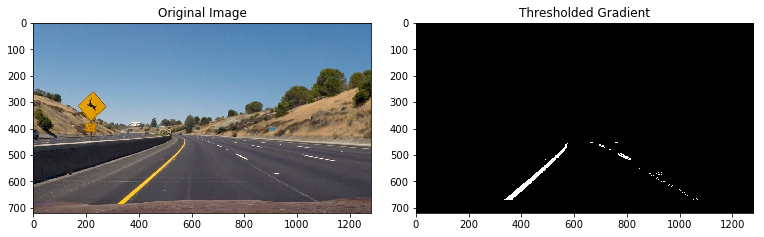

In [6]:
image = cv2.imread('test_images/test{}.jpg'.format(2))
combined = pipeline(image)

%matplotlib inline

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/thresholded_binary_output.png")

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [7]:
def get_PTmatrix(x, y):

    src = np.float32([[(x/2 - 150, y/2 + 100),
                       (x/2 + 150, y/2 + 100),
                       (x - 50,    y - 40),
                       (100,       y - 40)]])
    dst = np.float32([[(0,      0),
                       (x - 50, 0),
                       (x - 50, y),
                       (100,    y)]])

    return (cv2.getPerspectiveTransform(src, dst),
            cv2.getPerspectiveTransform(dst, src))

def corners_unwarp(undist, M, img_size):
    return cv2.warpPerspective(undist,
                               M,
                               img_size,
                               flags=cv2.INTER_LINEAR)

# warp the thresholded image so that we can fit second order
# polynomial to find road lanes
def warp_image(image, mtx, dist, M):
    # undistort
    undist = cal_undistort(image, mtx, dist)
    img_size = (image.shape[1], image.shape[0])
    # warp image
    return corners_unwarp(undist, M, img_size)

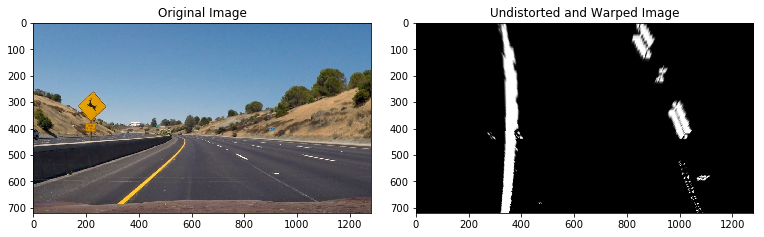

In [8]:
M, Minv = get_PTmatrix(image.shape[1], image.shape[0])
warped = warp_image(combined, mtx, dist, M)

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/warped_image.png")

## Detect lane pixels and fit to find the lane boundary.
Skip the sliding windows step once we know where the lines are

In [9]:
#Define Line class as suggested in the lecture

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        self.fit_history = deque(maxlen=6)
        self.fit_history_full = False

def radius_of_curvature(ploty, fitx):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    y_eval = np.mean(ploty)
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = (((1 +
                 (2*fit_cr[0]*y_eval*ym_per_pix +
                  fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0]))
    return curverad


# Locate the Lane Lines and Fit a Polynomial
def lane_detections(curv, lane, fit):
    lane.detected = True if ((lane.detected and abs(curv/lane.radius_of_curvature - 1) < 0.10) or
                             (lane.radius_of_curvature and abs(curv/lane.radius_of_curvature - 1) < 0.20) or
                             (not lane.detected and not lane.radius_of_curvature)) else False

    if lane.detected:
        lane.current_fit = fit
        lane.radius_of_curvature = curv
        lane.fit_history.appendleft(fit)
        lane.fit_history_full = len(lane.fit_history) == 6

# Line Finding Method: Peaks in a Histogram and Sliding Window
# Implement Sliding Windows and Fit a Polynomial
# With this histogram I am adding up the pixel values along
# each column in the image. In my thresholded binary image,
# pixels are either 0 or 1, so the two most prominent peaks
# in this histogram will be good indicators of the x-position
# of the base of the lane lines.
def lane_pixels(image, left_lane, right_lane):
    nwindows = 9
    margin = 100
    minpix = 50
    img = np.copy(image)
    
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if (left_lane.detected == False or
        right_lane.detected == False): 
        # Find the peak of the left and right halves of
        # the histogram. These will be the starting point
        # for the left and right lines
        
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Set height of windows
        
        window_height = np.int(img.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive
        # left and right lane pixel indices
        
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        
        for window in range(nwindows):
            
            # Identify window boundaries in x and y
            # (and right and left)
            
            win_y_low = (img.shape[0] -
                        (window+1)*window_height)
            win_y_high = (img.shape[0] -
                          window*window_height)
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y
            # within the window
            
            good_left_inds = ((nonzeroy >= win_y_low) &
                              (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) &
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) &
                               (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) &
                               (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter
            # next window on their mean position

            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(
                                    nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(
                                    nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    # Skip the sliding windows step once you know where the lines are
    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) +
                                       left_fit[1]*nonzeroy +
                                       left_fit[2] -
                                       margin)) &
                          (nonzerox < (left_fit[0]*(nonzeroy**2) +
                                       left_fit[1]*nonzeroy +
                                       left_fit[2] +
                                       margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) +
                                        right_fit[1]*nonzeroy +
                                        right_fit[2] -
                                        margin)) &
                           (nonzerox < (right_fit[0]*(nonzeroy**2) +
                                        right_fit[1]*nonzeroy +
                                        right_fit[2] +
                                        margin)))

    # Extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Measuring Curvature
    left_fitx = (left_fit[0]*ploty**2 +
                 left_fit[1]*ploty +
                 left_fit[2])
    right_fitx = (right_fit[0]*ploty**2 +
                  right_fit[1]*ploty +
                  right_fit[2])

    left_curvature = radius_of_curvature(ploty, left_fitx)
    right_curvature = radius_of_curvature(ploty, right_fitx)
    
    lane_detections(left_curvature, left_lane, left_fit)
    lane_detections(right_curvature, right_lane, right_fit)
    
    return

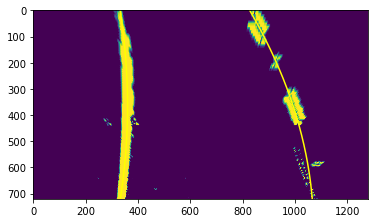

In [10]:
image = cv2.imread('test_images/test{}.jpg'.format(2))
combined = pipeline(image)
warped = warp_image(combined, mtx, dist, M)

left_lane = Line()
right_lane = Line()

lane_pixels(warped,left_lane,right_lane)

left_fit = left_lane.current_fit
right_fit = right_lane.current_fit
    
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = (left_fit[0]*ploty**2 +
             left_fit[1]*ploty +
             left_fit[2])
right_fitx = (right_fit[0]*ploty**2 +
              right_fit[1]*ploty +
              right_fit[2])

imgplot = plt.imshow(warped)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig("output_images/lines_on_warped_image.png")

## Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def car_position(image, left_fitx, right_fitx):
    xm_per_pix = 3.7/700
    center = image.shape[1]/2
    image_center = (left_fitx[-40] + right_fitx[-40])/2
    return (center - image_center) * xm_per_pix

def draw_lines(warped, image, left_lane, right_lane):
    if (left_lane.fit_history_full == True and
        right_lane.fit_history_full == True):
        left_fit = np.mean(left_lane.fit_history,axis=0)
        right_fit = np.mean(right_lane.fit_history,axis=0)
    else:   
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit

    ploty = np.linspace(0, warped.shape[0]-1,
                        warped.shape[0])
    left_fitx = (left_fit[0]*ploty**2 +
                 left_fit[1]*ploty +
                 left_fit[2])
    right_fitx = (right_fit[0]*ploty**2 +
                  right_fit[1]*ploty +
                  right_fit[2])

    # Create an image to draw the lines on
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,
                            warp_zero,
                            warp_zero))
    
    # Recast the x and y points into usable
    # format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(
                            np.vstack([left_fitx,
                                       ploty]))])
    pts_right = np.array([np.flipud(
                            np.transpose(
                                np.vstack([right_fitx,
                                           ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
     
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space
    # using inverse perspective matrix (Minv)
    
    img_size = (image.shape[1], image.shape[0])
    newwarp = cv2.warpPerspective(color_warp,
                                  Minv,
                                  img_size)
    
    # Combine the result with the original image
    undist = cal_undistort(image, mtx, dist)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #Put text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius = int((left_lane.radius_of_curvature +
                  right_lane.radius_of_curvature) / 2)
    text = "Radius of Curvature:{} m".format(radius)
    cv2.putText(result, text, (200,60), font, 1,
                (255,255,255),2)
    
    # Find the position of the car
    
    position = car_position(image, left_fitx, right_fitx)

    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result, text, (200,100), font, 1, (255,255,255), 2)
    
    return result

def mark_lane(image):
    
    combined = pipeline(image)
    warped = warp_image(combined, mtx, dist, M)
    lane_pixels(warped, left_lane, right_lane)
    result = draw_lines(warped, image, left_lane,right_lane)
    
    return result

## Warp the detected lane boundaries back onto the original image.

True

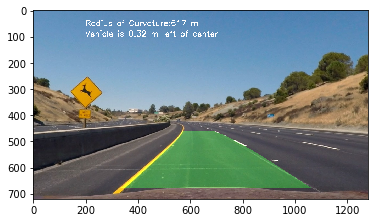

In [12]:
image = cv2.imread('test_images/test{}.jpg'.format(2))

left_lane = Line()
right_lane = Line()

marked_image = mark_lane(image)
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))

cv2.imwrite("output_images/lane_marked_on_original_image.png", marked_image)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lane = Line()
right_lane = Line()
output = 'project_video_output.mp4'
vc = VideoFileClip("project_video.mp4")
mi = vc.fl_image(mark_lane)
%time mi.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [12:35<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 11min 32s, sys: 1min 40s, total: 13min 13s
Wall time: 12min 37s
